In [ ]:
from utils import *
import torch 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import pickle
import pandas as pd

mnistdata = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=False,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=10000,
    shuffle=True,
)


with open('data/MNIST/fake_mnist.pckl', 'rb') as file:
    fake_mnist = pd.DataFrame( pickle.load(file)[0].reshape(10000, -1))


real_mnist = pd.DataFrame(next(iter(mnistdata))[0].reshape(10000, -1).detach().cpu().numpy())

real_mnist = real_mnist.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
fake_mnist = fake_mnist.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

sample_size = 150
N_iters = 20
NUM_CORES = 10
num_permutations = 200
kernel_name = 'euclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls = [0.1, 1, 10]
out = run_fast_parallel_sampling(real_mnist, fake_mnist, sample_size,  num_permutations,N_iters, NUM_CORES, kernel_name, ridge_ls, band_factor_ls , light = False, print_results = True)


     test_name  rejection_rate
0          KLR            0.50
1        *KLR*            0.40
2           CM            0.40
3  SpecReg-MMD            0.40
4         KLR0            0.25
5           FR            0.25
6      logdet2            0.20
7           HT            0.15
8       AggMMD            0.10


In [41]:

from utils import *
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10_1 = np.load("data/cifar/cifar10_1/cifar10.1_v6_data.npy")
cifar10 = torchvision.datasets.CIFAR10(root='./data/cifar/cifar10', train=True, download=False, transform=transform)
cifar10 = np.array([np.array(image.permute(1, 2, 0)) for image, _ in cifar10])*255  # convert CHW to HWC



def rgb_to_flat_greyscale(images):
    # Convert RGB to greyscale using standard luminosity
    greyscale = (
        0.299 * images[:, :, :, 0] +
        0.587 * images[:, :, :, 1] +
        0.114 * images[:, :, :, 2]
    )
    # Flatten (N, H*W)
    flattened = greyscale.reshape(greyscale.shape[0], -1)
    # Normalize to [0,1]
    return (flattened / 255.0).astype(np.float32)


# CIFAR-10.1 loaded as NumPy array (shape e.g. (2000, 32, 32, 3))
cifar10_1_flat = rgb_to_flat_greyscale(cifar10_1)

# CIFAR-10 images loaded as a NumPy array of PIL images converted to np arrays (shape e.g. (50000, 32, 32, 3))
cifar10_flat = rgb_to_flat_greyscale(cifar10)

pd_cifar10_1 = pd.DataFrame(cifar10_1_flat)
pd_cifar10 = pd.DataFrame(cifar10_flat)


In [ ]:


N_iters = 1
NUM_CORES = 1
num_permutations = 200
kernel_name = 'euclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls = [0.1, 1, 10]

sample_size = 50
results = []

out = run_fast_parallel_sampling(
    pd_cifar10, pd_cifar10_1, sample_size,
    num_permutations, N_iters, NUM_CORES,
    kernel_name, ridge_ls, band_factor_ls, light=False
)
print(out)

[{'KLR': False, 'KLR0': False, '*KLR*': False, 'logdet2': False, 'CM': False, 'SpecReg-MMD': False, 'AggMMD': False, 'HT': False, 'FR': False}]


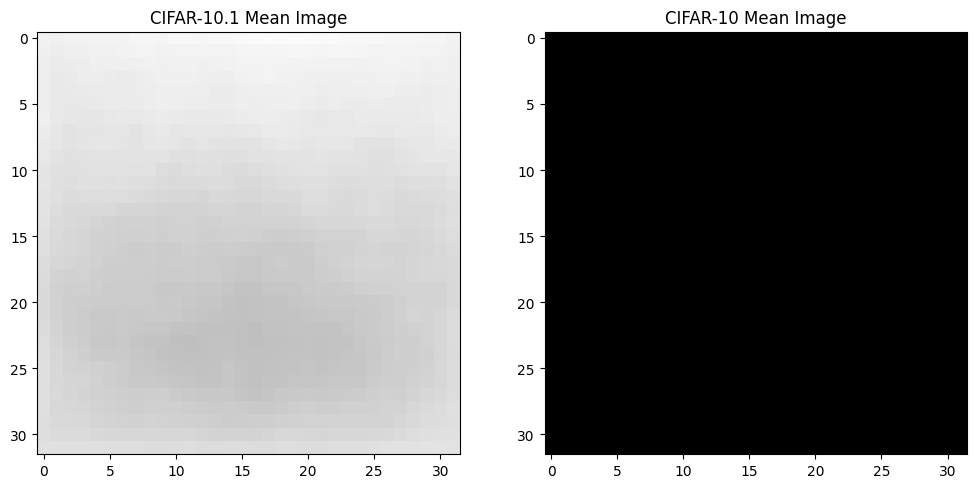

In [ ]:

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))
vmin = min(pd_cifar10_1.sample(1000).mean(axis=0).min(), pd_cifar10.sample(1000).mean(axis=0).min())
vmax = max(pd_cifar10_1.sample(1000).mean(axis=0).max(), pd_cifar10.sample(1000).mean(axis=0).max())

ax.imshow(pd_cifar10_1.sample(1000).mean(axis=0).values.reshape(32, 32), cmap='gray', vmin=vmin, vmax=vmax)
ax.set_title("CIFAR-10.1 Mean Image")
ax1.imshow(pd_cifar10.sample(1000).mean(axis=0).values.reshape(32, 32), cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title("CIFAR-10 Mean Image")
plt.show()

<Axes: >

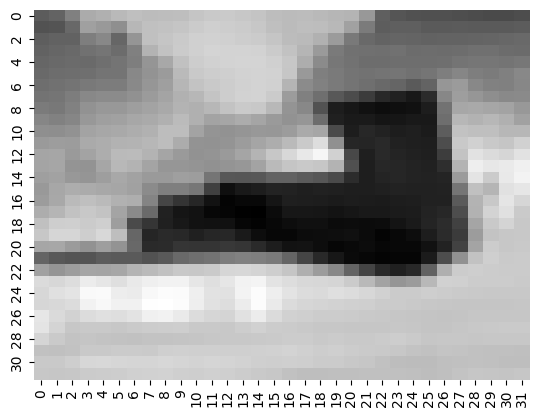

In [19]:
import seaborn as sns

images = cifar10_1[:10]
# images = cifar10[:10]

greyscale = (
    0.299 * images[:, :, :, 0] +
    0.587 * images[:, :, :, 1] +
    0.114 * images[:, :, :, 2]
)
sns.heatmap(greyscale[0], cmap='gray', cbar=False)

In [ ]:
from utils import *
num_permutations = 200
kernel_name = 'euclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls = [0.1, 1, 10]
sample_size = 50
out = run_fast_parallel_sampling(
    pd_cifar10, pd_cifar10, sample_size,
    num_permutations, 1, 1,
    kernel_name, ridge_ls, band_factor_ls, light=False
)

In [29]:
out

[{'KLR': False,
  'KLR0': False,
  '*KLR*': False,
  'logdet2': False,
  'CM': False,
  'SpecReg-MMD': False,
  'AggMMD': False,
  'HT': False,
  'FR': False}]

# MNIST

In [ ]:
import cv2

def Blurring(X, K):
    """
    Blur the data by convolving with Gaussian kernel
    
    Parameters:
    - X: np.ndarray, shape (n_samples, n_features)
        The input data to perturb.
    - sigma: float
        The standard deviation of the Gaussian kernel to pass through.
    - K: int
        The size of the Gaussian kernel (must be odd).
        
    Returns:
    - np.ndarray, shape (n_samples, n_features)
        The perturbed data.
    """
    X += np.random.normal(0, .05, X.shape)
    if len(X.shape)==1:
        return cv2.blur(X.reshape(28, 28), (K, K)).flatten()
    elif len(X.shape)==2:
        return np.array([cv2.blur(x.reshape(28, 28), (K, K)).flatten() for x in X])
    else:
        raise ValueError("Input data must be 1D or 2D array.")

In [ ]:
from utils import *
from sklearn.preprocessing import StandardScaler

mnist_data_train = pd.read_csv('datasets/MNIST/mnist_train.csv').set_index('label')/255

In [ ]:

NUM_CORES = 8
num_replications = 8
num_samples = 60
num_permutations = 200
kernel_name = 'sqeuclidean'
ridge_ls = np.logspace(-7, 0, 8)
# band_factor_ls = [0.03, 0.1, 1, 3, 10, 30]
band_factor_ls = [0.05, 0.1, 1, 5,10]
# h_low = 2
# h_up = 2
# band_factor = 10 ** np.arange(-h_low, h_up + 0.01, 0.5)

## PREPARE DATA
group_1 = [0,1,6,8]; group_2 = [0,6,8]
# group_1 = [1]; group_2 = [7]
# group_1 = [0,6,8]; group_2 = [6,6,8]

XYpairs = []
for _ in range(num_replications):
    X_samples = np.concatenate([ mnist_data_train.loc[el].sample(num_samples//len(group_1)).values for el in group_1])
    Y_samples = np.concatenate([ mnist_data_train.loc[el].sample(num_samples//len(group_2)).values for el in group_2])
    XYpairs.append((X_samples, Y_samples))

# BLURRING
K = 12
iter_args = [(Blurring(X, K), Blurring(Y, K),  num_permutations, kernel_name, ridge_ls,band_factor_ls ) for (X, Y) in XYpairs]
      
# ## WHITE NOISE
# sigma = .4
# iter_args = [ ( X + np.random.normal(0, sigma, X.shape),  Y + np.random.normal(0, sigma, X.shape), num_permutations, kernel_name, ridge_ls,band_factor_ls ) for (X, Y) in XYpairs]

# --- RUNNING THE TESTS
results = pd.DataFrame(Parallel(n_jobs=NUM_CORES)( delayed(run_fast)(*args) for args in tqdm(iter_args, total=len(iter_args), ncols=100, position=0))).T.mean(1)
results.sort_values()



100%|███████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 3346.41it/s]


FR             0.000
KLR            0.750
KLR0           0.750
SpecReg-MMD    0.750
HT             0.750
AggMMD         0.875
dtype: float64

------

<Axes: >

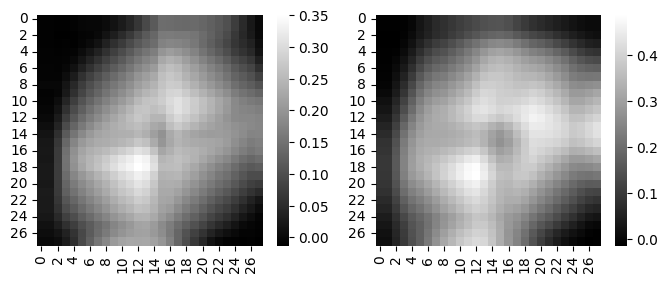

In [ ]:
K = 5
iter_args = [(Blurring(X, K), Blurring(Y, K),  num_permutations, kernel_name, ridge,band_factor ) for (X, Y) in XYpairs]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap(iter_args[0][0][0].reshape(28, 28), cmap='gray', cbar=True, ax=ax0)
sns.heatmap(iter_args[0][0][1].reshape(28, 28), cmap='gray', cbar=True, ax=ax1)

sigma = 0.75
iter_args = [ ( X + np.random.normal(0, sigma, X.shape),  Y + np.random.normal(0, sigma, X.shape), num_permutations, kernel_name, ridge,band_factor ) for (X, Y) in XYpairs]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap(iter_args[0][0][0].reshape(28, 28), cmap='gray', cbar=True, ax=ax0)
sns.heatmap(iter_args[0][0][1].reshape(28, 28), cmap='gray', cbar=True, ax=ax1)


# sklear-datasets

In [ ]:
# from sklearn.datasets import load_digits
# data = load_digits()

from sklearn.datasets import fetch_lfw_pairs
data = fetch_lfw_pairs()

# from sklearn.datasets import fetch_openml
# data = fetch_openml('mnist_784', version=1)

X, y = data.data/255, data.target
pd_data = pd.DataFrame(data = X, index = y)

In [ ]:

NUM_CORES = 8
num_replications = 8
num_samples = 100
num_permutations = 200
kernel_name = 'sqeuclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls = [0.05, 0.1, 1, 5,10]

# group_1 = [0,1,6,8]; group_2 = [0,6,8]
group_1 = [0]; group_2 = [1]

XYpairs = []
for _ in range(num_replications):
    X_samples = np.concatenate([ pd_data.loc[el].sample(num_samples//len(group_1)).values for el in group_1])
    Y_samples = np.concatenate([ pd_data.loc[el].sample(num_samples//len(group_2)).values for el in group_2])
    XYpairs.append((X_samples, Y_samples))

## BLURRING
# K = 12
# iter_args = [(Blurring(X, K), Blurring(Y, K),  num_permutations, kernel_name, ridge_ls,band_factor_ls ) for (X, Y) in XYpairs]
      
## WHITE NOISE
sigma = 0
iter_args = [ ( X + np.random.normal(0, sigma, X.shape),  Y + np.random.normal(0, sigma, X.shape), num_permutations, kernel_name, ridge_ls,band_factor_ls ) for (X, Y) in XYpairs]

# --- RUNNING THE TESTS
results = pd.DataFrame(Parallel(n_jobs=NUM_CORES)( delayed(run_fast)(*args) for args in tqdm(iter_args, total=len(iter_args), ncols=100, position=0))).T.mean(1)
results.sort_values()



100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 31.90it/s]


KLR            0.125
KLR0           0.125
AggMMD         0.125
SpecReg-MMD    0.250
FR             0.500
HT             0.625
dtype: float64

In [ ]:
K = 5
iter_args = [(Blurring(X, K), Blurring(Y, K),  num_permutations, kernel_name, ridge,band_factor ) for (X, Y) in XYpairs]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap(iter_args[0][0][0].reshape(28, 28), cmap='gray', cbar=True, ax=ax0)
sns.heatmap(iter_args[0][0][1].reshape(28, 28), cmap='gray', cbar=True, ax=ax1)

sigma = 0.75
iter_args = [ ( X + np.random.normal(0, sigma, X.shape),  Y + np.random.normal(0, sigma, X.shape), num_permutations, kernel_name, ridge,band_factor ) for (X, Y) in XYpairs]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap(iter_args[0][0][0].reshape(28, 28), cmap='gray', cbar=True, ax=ax0)
sns.heatmap(iter_args[0][0][1].reshape(28, 28), cmap='gray', cbar=True, ax=ax1)


ValueError: cannot reshape array of size 5828 into shape (28,28)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from torch.utils.data import DataLoader
from scipy.stats import mode
from utils import *

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to grayscale
    transforms.ToTensor(),                        # Convert to (1, 32, 32) tensor
    transforms.Normalize((0.5,), (0.5,))          # Normalize grayscale channel
])
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

X = []
y = []
for img, label in cifar10_test:
    # img is a torch tensor of shape (1, 32, 32), already grayscale
    X.append(img.numpy().flatten())  # flatten to (1024,)
    y.append(label)
X = np.array(X)
y = np.array(y)
pd_data = pd.DataFrame(data = X, index = y)

X.shape


Files already downloaded and verified


(10000, 1024)

In [ ]:

NUM_CORES = 8
num_replications = 8
num_samples = 25
num_permutations = 200
kernel_name = 'sqeuclidean'
ridge_ls = np.logspace(-7, 0, 8)
band_factor_ls = [0.05, 0.1, 1, 5,10]

# group_1 = [0,1,6,8]; group_2 = [0,6,8]
group_1 = [4]; group_2 = [7]

XYpairs = []
for _ in range(num_replications):
    X_samples = np.concatenate([ pd_data.loc[el].sample(num_samples//len(group_1)).values for el in group_1])
    Y_samples = np.concatenate([ pd_data.loc[el].sample(num_samples//len(group_2)).values for el in group_2])
    XYpairs.append((X_samples, Y_samples))

iter_args = [ ( X,  Y , num_permutations, kernel_name, ridge_ls,band_factor_ls ) for (X, Y) in XYpairs]

# --- RUNNING THE TESTS
results = pd.DataFrame(Parallel(n_jobs=NUM_CORES)( delayed(run_fast)(*args) for args in tqdm(iter_args, total=len(iter_args), ncols=100, position=0))).T.mean(1)
results.sort_values()



100%|███████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2242.04it/s]


FR             0.000
KLR            0.375
SpecReg-MMD    0.500
HT             0.500
KLR0           0.625
AggMMD         0.875
dtype: float64

In [ ]:
print(band_factor)

[1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02]


<Axes: >

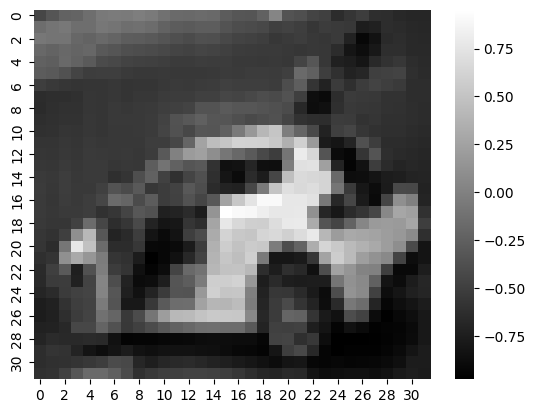

In [ ]:
sns.heatmap(pd_data.loc[1].iloc[0].values.reshape(32, 32), cmap='gray', cbar=True)

In [ ]:
pd_data.loc[0].iloc[0].values.shape

(3072,)

In [ ]:
32*32

1024

In [ ]:
# N_iters = 2; n = 10; n_d_values = [(10,50), (10,100)]; num_permutations = 2


In [ ]:
n,m = 100,100
X  = _model_(**model_params)(d).sample_X(n)
Y  = _model_(**model_params)(d).sample_Y(m)
fullsample = np.concatenate([X, Y])
pairwise_dists = cdist(fullsample, fullsample, 'euclidean')
bandwidth = 2 * np.median(pairwise_dists[pairwise_dists>0])
kernel_matrix  =  np.exp( - pairwise_dists / (bandwidth)) 

KX = kernel_matrix[:n, :n]
KY = kernel_matrix[n:, n:]

Id = np.eye(n+n)
perm = np.random.permutation(n + m)
P = Id[perm]
_kernel_matrix = P @ kernel_matrix @ P.T 


_kernel_matrix = centered_kernel_matrix[np.ix_(perm := np.random.permutation(n + m), perm)]


In [ ]:
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from scipy.stats import norm
from utils.other_tests import *
import pandas as pd
import math

def wilson_score_interval(successes, n, confidence=0.95):
    z = norm.ppf(1 - (1 - confidence) / 2)  # z-score for desired confidence level
    phat = successes / n
    denominator = 1 + z**2 / n
    center = phat + z**2 / (2 * n)
    margin = z * math.sqrt((phat * (1 - phat) + z**2 / (4 * n)) / n)
    lower = (center - margin) / denominator
    upper = (center + margin) / denominator
    return lower.round(3), upper.round(3)
# from utils.other_tests import *


def reorder_kernel(kernel_matrix, permuted_indices_1, permuted_indices_2):
    return kernel_matrix[permuted_indices_1, :][:, permuted_indices_2]

def split_kernel(kernel_matrix,n,m):
    kxx = kernel_matrix [:n, :n]
    kyy = kernel_matrix [m:, m:]
    kxy = kernel_matrix [:n, m:]  
    return kxx, kyy, kxy  

def sqrtm_ED(eigdec):
    S, U = eigdec
    S = np.clip(S, 1e-15, None)  # Avoid sqrt(0)
    return U @ np.diag(np.array([s**0.5 if s > 0 else 0 for s in S])) @ U.T

def inv_ED(eigdec):
    S, U = eigdec
    S = np.clip(S, 1e-15, None)  # Avoid sqrt(0)
    return U @ np.diag(np.array([1/s if s > 0 else 0 for s in S])) @ U.T

def inv_sqrtm_ED(eigdec):
    S, U = eigdec
    S = np.clip(S, 1e-15, None)  # Avoid sqrt(0)
    return U @ np.diag(np.array([s**-0.5 if s > 0 else 0 for s in S])) @ U.T

# ------------------------------------------------------------------------------------------------------------------------------------------
def update_dict(original, kernel_matrix, ridge_ls, BF, ):
    tol = 1e-10
    islist = original.default_factory == list
    n =  kernel_matrix.shape[0]//2; m = n
    kxx, kyy, kxy = split_kernel(kernel_matrix, n, m); kyx = kxy.T
    # mY = np.sum( np.concatenate([kyx, kyy]), axis=1, keepdims=True)/n
    # mX = np.sum( np.concatenate([kxx, kxy]), axis=1, keepdims=True)/m
    KmatX = np.concatenate([kxx, kyx])
    KmatY = np.concatenate([kxy, kyy])
    mX = np.mean(KmatX, axis=1, keepdims=True)
    mY = np.mean(KmatY, axis=1, keepdims=True)
    SX = KmatX @ (KmatX.T)/n 
    SY = KmatY @ (KmatY.T)/m
    # SX = np.cov(KmatX)
    # SY = np.cov(KmatY)
    # S_avg = .5*(SX + SY)
    # m_avg = .5*(mX + mY)

    smartreg = 0.5
    S_avg = (1-smartreg)*SX+smartreg*SY
    m_avg = (1-smartreg)*mX+smartreg*mY

    C = np.cov(kernel_matrix.T)
    eigvals_C, eigvecs_C = np.linalg.eigh(C+ np.eye(n+m)*1e-15)
    eigvals_S_avg, eigvecs_Savg = np.linalg.eigh(S_avg + np.eye(n+m)*1e-15)

    project_dim = n + n//3
    projection_matrix = eigvecs_Savg[:, -project_dim:] @ eigvecs_Savg[:, -project_dim:].T
    # S_avg = projection_matrix @ S_avg @ projection_matrix.T
    SY = projection_matrix @ SY @ projection_matrix.T
    # SX = projection_matrix @ SX @ projection_matrix.T

    for r in ridge_ls:
        inv_sqrtm_S_avg = inv_sqrtm_ED((eigvals_S_avg + r, eigvecs_Savg))
        
        innerHSmat_eigvals = .5*np.linalg.eigvalsh(inv_sqrtm_S_avg @ ((S_avg-SY)) @ inv_sqrtm_S_avg)    
        innerHSmat_eigvals = np.clip(innerHSmat_eigvals, 1e-15 - 1, None)  # Avoid log(0)]
        logdet2_term = np.abs(- np.sum(innerHSmat_eigvals) + np.sum(np.log(1 + innerHSmat_eigvals)))
        CM_term = .5*np.linalg.norm(inv_sqrtm_S_avg @ ((m_avg - mX)))
        HS_term = np.sum(innerHSmat_eigvals**2)**.5 - tol
        KLR_term = CM_term + logdet2_term - tol
        specreg_term = np.linalg.norm(inv_sqrtm_ED((eigvals_C + r, eigvecs_C))@(mY-mX)) - tol
        if islist:
            original['KLR', r, BF].append(KLR_term)
            original['KLR0', r, BF].append(HS_term)
            original['SpecReg-MMD', r, BF].append(specreg_term)
        else:
            original['KLR', r, BF] = KLR_term
            original['KLR0', r, BF] = HS_term
            original['SpecReg-MMD', r, BF] = specreg_term
    if islist:
        original['AggMMD', BF].append(np.linalg.norm(mX - mY))
    else:
        original['AggMMD', BF] = np.linalg.norm(mX - mY)
    return original

def run_fast(X,Y, num_permutations, kernel_name, ridge_ls, band_factor_ls, light = False, return_all = False):
    n = len(X); m = len(Y)
    fullsample = np.concatenate([X, Y])
    pairwise_dists = cdist(fullsample, fullsample, kernel_name)
    centered_fullsample = np.concatenate([X - X.mean(0) + fullsample.mean(0) , Y - Y.mean(0) + fullsample.mean(0)])
    centered_pairwise_dists = pairwise_dists.copy()
    # centered_pairwise_dists = cdist(centered_fullsample, centered_fullsample, kernel_name)
    bandwidth = 2 * np.median(pairwise_dists[pairwise_dists>0])
    obs_value = defaultdict()
    p_values = []
    obs_value, permuted_values = defaultdict(), defaultdict(list)
    for BF in band_factor_ls:
        kernel_matrix  =  np.exp( - pairwise_dists / (bandwidth*BF)) 
        centered_kernel_matrix =  np.exp( - centered_pairwise_dists / (bandwidth*BF)) 

        obs_value = update_dict(obs_value, kernel_matrix, ridge_ls, BF)
        for _ in range(num_permutations):
            _kernel_matrix = centered_kernel_matrix[np.ix_(perm := np.random.permutation(n + m), perm)]
            permuted_values =  update_dict(permuted_values, _kernel_matrix, ridge_ls, BF)
    
    adj_obs_value = {key : val - 1e-7 for key, val in obs_value.items()}    
    p_values = defaultdict(list)
    for key, values in permuted_values.items():
        name = key[0]
        p_values[name].append( np.mean(np.array(values) > adj_obs_value[key] ))

    if not light:
        p_values['HT'] = [ HT_two_sample_test(X,Y)(num_permutations)[1] ]
        p_values['FR'] = [ FR_two_sample_test(X,Y)(num_permutations)[1] ]
    
    if return_all:
        return p_values, adj_obs_value, permuted_values
    return {name: min(ps) < 0.05/len(ps) for name, ps in p_values.items()}

def run_fast_parallel(n, d,  _model_, model_params, num_permutations, N_iters, NUM_CORES, kernel_name, ridge, band_factor , light = False, print_results = False):
    iter_args = [(_model_(**model_params)(d).sample_X(n), _model_(**model_params)(d).sample_Y(n),
                   num_permutations, kernel_name, ridge, band_factor, light) for _ in range(N_iters)]
    out = Parallel(n_jobs=NUM_CORES)(delayed(run_fast)(*args) for args in iter_args)
    if print_results:
        try:
            results = [[n, d, test_name, np.mean( [_[test_name] for _ in out]), wilson_score_interval(np.sum( [_[test_name] for _ in out]), 8)] for test_name in out[0].keys()]
            data = pd.DataFrame(results, columns=['sample_size', 'dimension', 'test_name', 'rejection_rate', 'CI'])
        except:
            results = [[n, d, test_name, np.mean( [_[test_name] for _ in out])] for test_name in out[0].keys()]
            data = pd.DataFrame(results, columns=['sample_size', 'dimension', 'test_name', 'rejection_rate'])
        print(data.sort_values(by=['rejection_rate'], ascending=False).reset_index(drop=True))
    return out




def get_mvecs_X_Y(kxx, kxy, kyy):
    kyx = kxy.T
    n = kxx.shape[0]
    m = kyy.shape[0]
    mY = np.sum( np.concatenate([kxx, kyx]), axis=1, keepdims=True)/n
    mX = np.sum( np.concatenate([kxy, kyy]), axis=1, keepdims=True)/m
    return mX, mY

def get_Smats_X_Y(kxx, kxy, kyy):
    kyx = kxy.T
    n = kxx.shape[0]
    m = kyy.shape[0]
    KmatX = np.concatenate([kxx, kyx])
    KmatY = np.concatenate([kxy, kyy])
    SX = KmatX @ (KmatX.T)/n 
    SY = KmatY @ (KmatY.T)/m 
    return SX, SY
    # return .5*(SX + SY), SY

def get_Cmat(kernel_matrix):
    N = kernel_matrix.shape[0]
    m_emb = np.sum(kernel_matrix, axis=1, keepdims=True)/N
    return kernel_matrix@(kernel_matrix.T)/ N  - m_emb@(m_emb.T) 

In [ ]:
import os
from pathlib import Path

# Define the source directory
src_dir = Path("sims")

# Make sure it's a directory
if not src_dir.is_dir():
    raise NotADirectoryError(f"{src_dir} is not a valid directory")

# Iterate over all .py files
for script_path in src_dir.glob("*.py"):
    # Get the name of the new script
    new_script_path = script_path.parent / f"_alternative_{script_path.name}"

    # Write the new script
    with open(new_script_path, "w") as f:
        f.write("null = False\n")
        f.write(f"exec(open('src/sims/{script_path.name}').read())\n")